In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path =  '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'amoc'
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum  = 'blue2red', 15
cref, crange, cmin, cmax, cfac, climit = 0.0, None, None, None, None, None
chist, ctresh = True, 0.995

# ref_cstr, ref_cnum = 'wbgyr', 15
# ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = 0.0, None, None, None, None, None
# ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
which_lat         = 26.5 # 'max' # 'max', 26.0
which_transf      = 'dmoc'
do_zcoord         = False
do_useZinfo       = 'std_dens_H' #from where provide zinfo for projection to zcoord, options: 'std_dens_H', 'density_dMOC', 'std_dens_Z'

ncol              = 2      # number of pannel columns in figure
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
do_enum           = False  # do enumeration of panels
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True #True/False
do_rapid          = False

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
#     #__________________________________________________________________________________________________
#     if (ref_path is not None): 
#         aux_path, aux_name = list(), list()
#         ref_path_old, ref_name_old = ref_path, ref_name
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(ref_name))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
#             print('R', ref_path[-1])        
#         ref_path, ref_name = aux_path, aux_name
#     del(aux_path, aux_name)  
    
##______________________________________________________________________________________________________        
# cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
#     ref_cinfo['cref']=0.0 

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        

## ______________________________________________________________________________________________________    
## concatenate list = list1+list2
# if (ref_path is not None): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths        , ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
  
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


### ATTENTION:
use here the density MOC levels that are specfic for your run. They might be different from the one im using here since they might need to be customized specific to your hydrography to be able to cover the whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

In [5]:
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]


In [6]:
zdefuc,zdeflc = [200,3000], [800, 6000]
ddefuc,ddeflc = [36.0, 36.80], [36.0, 37.8]

data_list    = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5  # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
         
        #____________________________________________________________________________________________________
        # load DMOC std_* data --> combined in xarray dataset
        data = tpv.load_dmoc_data(mesh, datapath, descript, year_chnk, which_transf, std_dens, do_info=False, 
                                  do_tarithm=None, do_zcoord=do_zcoord, do_useZinfo=do_useZinfo, 
                                  do_bolus=do_bolus, add_bolus=True, do_load=False, do_persist=True, )
        #____________________________________________________________________________________________________
        # compute moc profile over time
        dmoc      = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_load=True,
                                  do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        #____________________________________________________________________________________________________
        # compute time-series
        
        # --> if the correct information for density class z position is available define upper lower cell 
        # by depth criteria zdefuc,zdeflc
        if 'ndens_zfh' in list(dmoc.keys()):
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens_zfh']>=zdefuc[0]) & (dmoc['ndens_zfh']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        # --> if there is no correct information for density class z position define upper lower cell 
        # by density criteria ddefuc,ddeflc
        else:
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens']>=ddefuc[0]) & (dmoc['ndens']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        if nchnk==0: dmoc_t = dmoc_tchnk
        else       : dmoc_t = xr.concat([dmoc_t, dmoc_tchnk], dim='time')
        
        #____________________________________________________________________________________________________
        del(data, dmoc, dmoc_tchnk)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(dmoc_t)    
    print('        elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))
    del(dmoc_t)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012
        2013|2014|2015|2016|2017
        2018|2019
                elapsed time: 2.26min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|

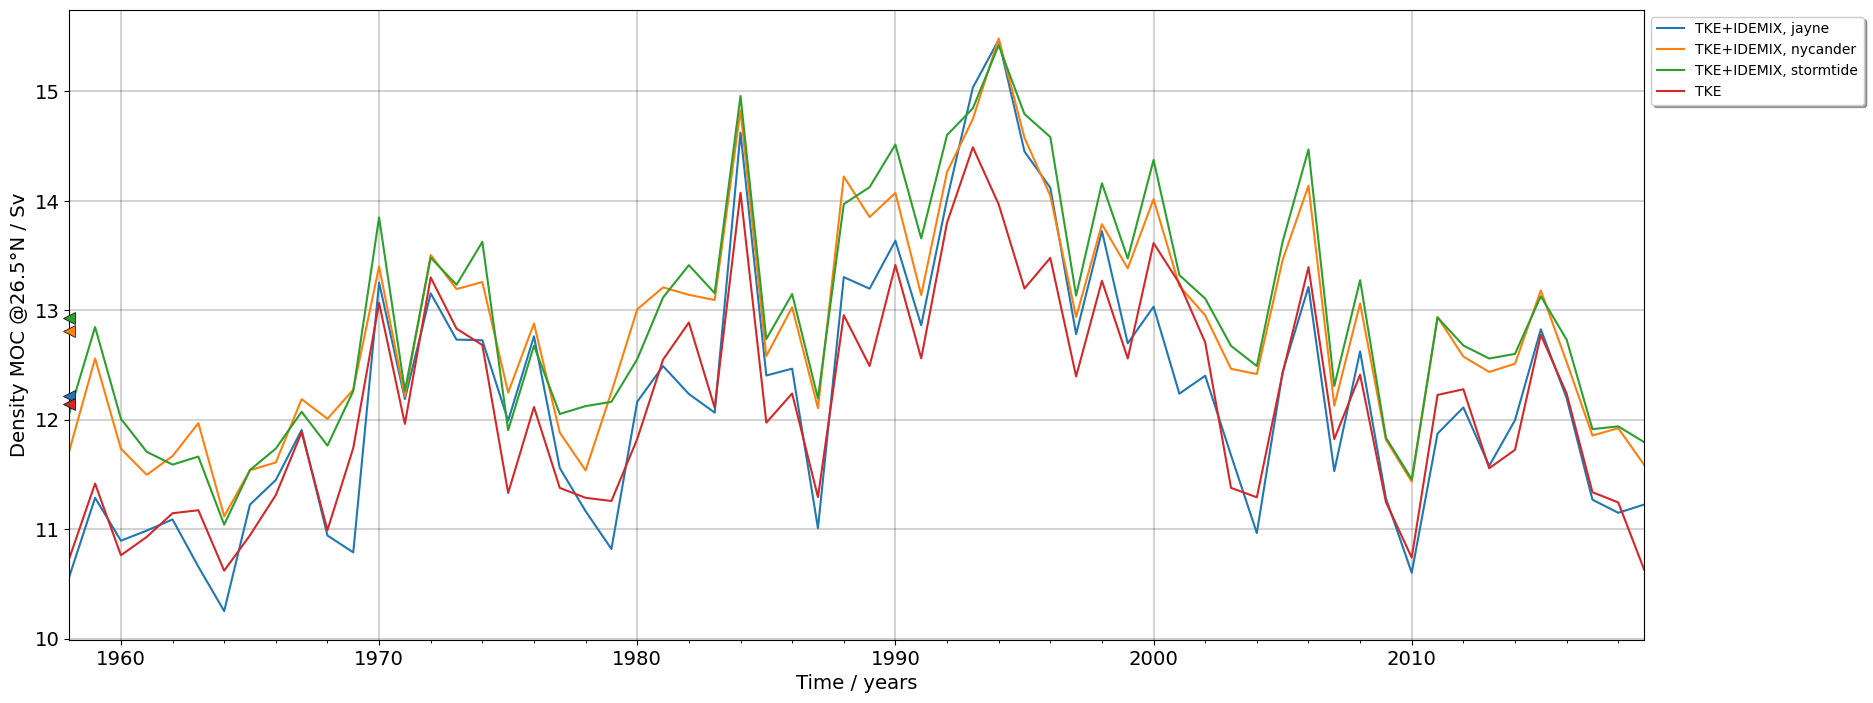

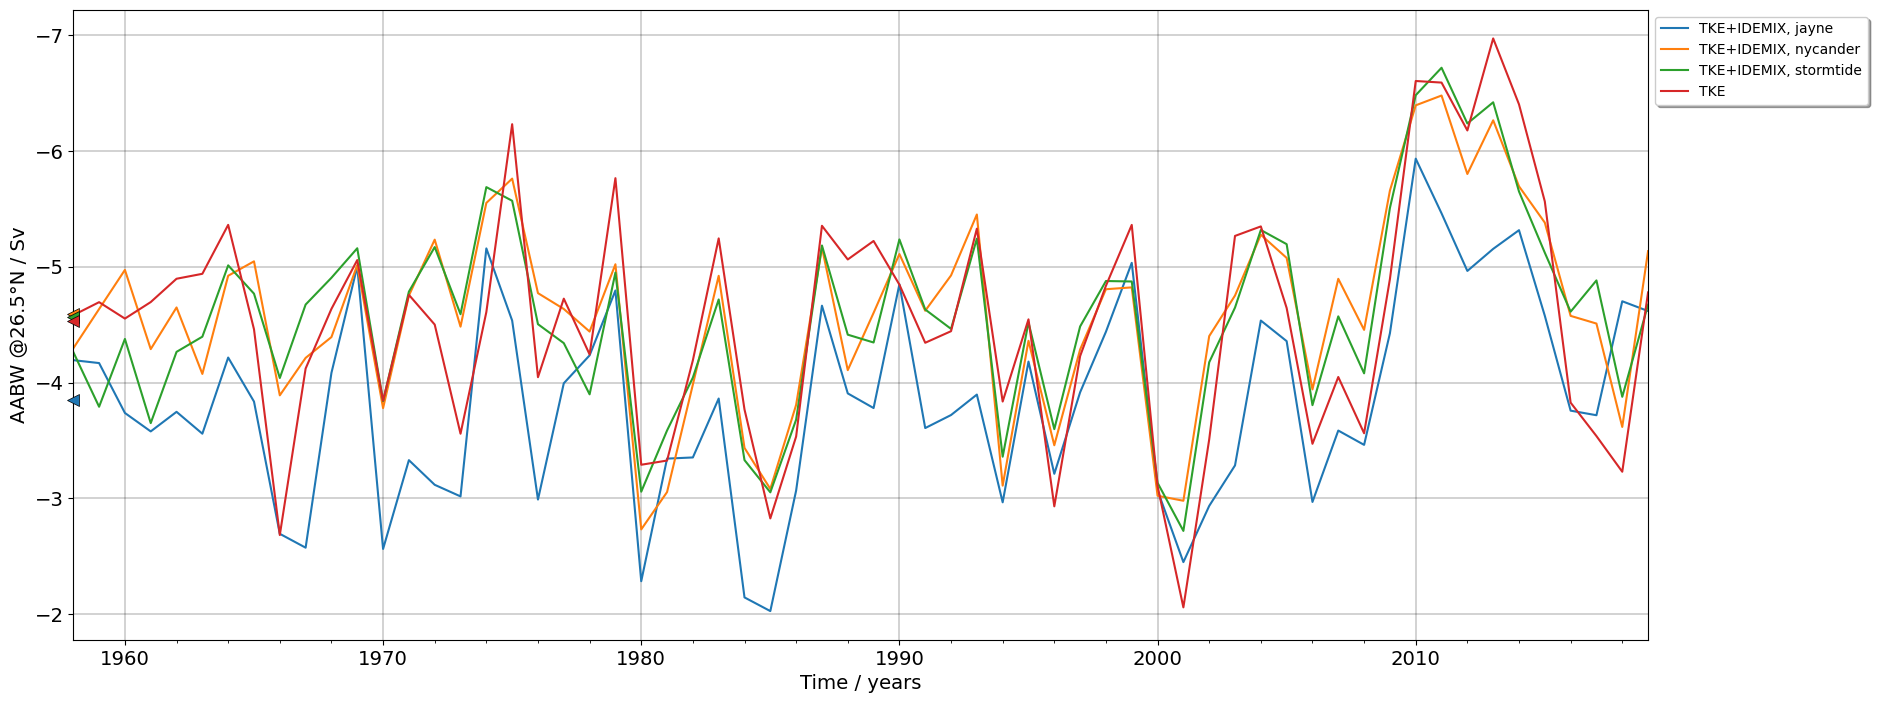

In [8]:
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
for lat in which_lat: 
    lat_list = list()
    for data in data_list:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['dmoc_nadw','dmoc_ucell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    slabel = lat_list[0][0][svname].attrs['str_lsave']
    stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_ucell', stname ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )            

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
for lat in which_lat: 
    lat_list = list()
    for data in data_list:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['dmoc_aabw','dmoc_lcell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                data_lat[var].attrs['short_name'] = 'AABW'
                data_lat[var].attrs['long_name']  = 'AABW'
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    slabel = lat_list[0][0][svname].attrs['str_lsave']
    stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_lcell', stname ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            grid_opt   = dict({'do_yinvert':True}),
                            do_enum    = do_enum                  ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )